# **Without Quantization**

In [3]:
import tensorflow as tf

# Check if TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
from tensorflow.keras import layers
import os
os.environ['AUTOGRAPH_VERBOSITY'] = '0'
import warnings
warnings.filterwarnings('ignore')

def create_model():
    model = tf.keras.models.Sequential([
        # 3x3 convolutional layer, 32 channels, ReLU activation, same padding
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        # 2x2 max pooling
        layers.MaxPooling2D((2, 2)),
        # 3x3 convolutional layer, 64 channels, ReLU activation, same padding
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        # 2x2 max pooling
        layers.MaxPooling2D((2, 2)),
        # 3x3 convolutional layer, 64 channels, ReLU activation, same padding
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        # 2x2 max pooling
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        # Fully connected layer with 128 units, ReLU activation
        layers.Dense(128, activation='relu'),
        # Softmax output layer with 10 units
        layers.Dense(10, activation='softmax')
    ])

    return model


In [5]:
import numpy as np

def aggregate_models(models, weights, return_model=True):
    new_model = create_model()
    model_weights = [model.get_weights() for model in models]
    new_weights = []
    for i in range(len(model_weights[0])):
        layer_weights = [model[i] for model in model_weights]
        avg_layer_weights = np.average(layer_weights, axis=0, weights=weights)
        new_weights.append(avg_layer_weights)
    new_model.set_weights(new_weights)
    return new_model if return_model else new_weights

In [6]:
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

N = 10
x_train_split = np.array_split(x_train, N)
y_train_split = np.array_split(y_train, N)
print(x_train_split[0].shape, y_train_split[0].shape)


indices = np.arange(x_test.shape[0])
np.random.shuffle(indices)
x_test = x_test[indices]
y_test = y_test[indices]

x_test_split = np.array_split(x_test, 1)
y_test_split = np.array_split(y_test, 1)

11490434/11490434 [==============================] - 0s 0us/step
(6000, 28, 28, 1) (6000,)


In [7]:
def get_mini_batch(x, y, mini_batch_size):
    num_samples = len(x)
    indices = np.random.choice(num_samples, mini_batch_size, replace=False)
    return x[indices], y[indices]

In [10]:
from tqdm import tqdm
global_model = create_model()
models = [create_model() for _ in range(N)]
epochs = 25
ACCs = []
LOSSes = []
tau = 4
for _ in tqdm(range(epochs)):
    for i in range(N):    
        model = create_model()
        model.set_weights(global_model.get_weights())
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#         model.fit(x_train_split[i], y_train_split[i], epochs=10, verbose=0)
        for j in range(tau):
            xj, yj = get_mini_batch(x_train_split[i], y_train_split[i], 500)
            with tf.GradientTape() as tape:
                predictions = model(xj)
                loss = tf.keras.losses.sparse_categorical_crossentropy(yj, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        models[i].set_weights(model.get_weights())
    global_model = aggregate_models(models, [x_train_split[i].shape[0]/60000 for i in range(N)])#weights)
    global_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    loss, acc = global_model.evaluate(x_test, y_test, verbose=0)
    ACCs.append(acc)
    LOSSes.append(loss)

100%|██████████| 25/25 [05:10<00:00, 12.44s/it]


In [11]:
import pickle
data = {'Loss': LOSSes, 'Accuracy': ACCs}
with open('without_quantization.pkl', 'wb') as f:
    pickle.dump(data, f)
global_model.save('without_quantization.h5')

In [ ]:
# from tensorflow.keras.models import load_model
# loaded_model = load_model('without_quantization.h5')
# with open('without_quantization.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)
# LOSSes = loaded_data['Loss']
# ACCs = loaded_data['Accuracy']

313/313 [==============================] - 1s 2ms/step
(10000, 10)
Test accuracy: 0.9609


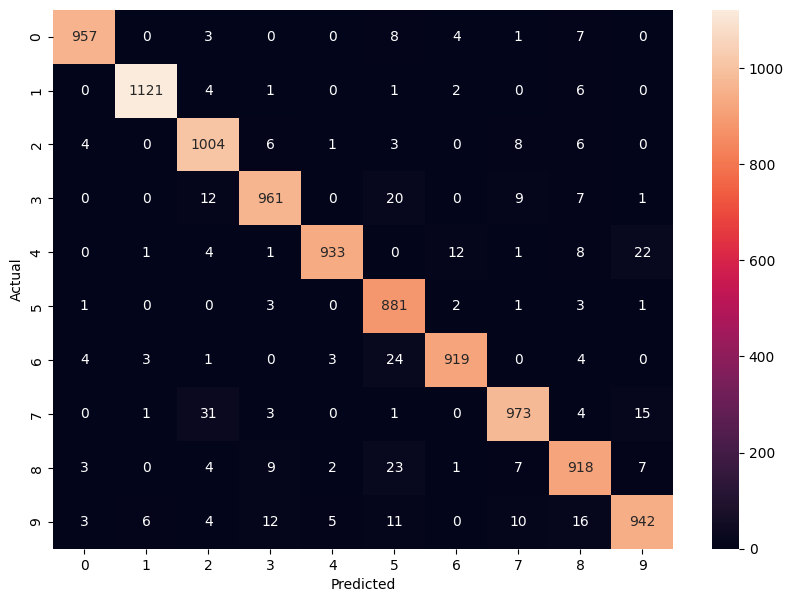

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_pred = global_model.predict(x_test)
print(y_pred.shape)

y_pred_classes = np.argmax(y_pred, axis = 1) 

confusion_mtx = confusion_matrix(y_test, y_pred_classes) 

accuracy = accuracy_score(y_test, y_pred_classes)

print(f'Test accuracy: {accuracy}')
plt.figure(figsize=(10,7))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **With Stochastic Quantization**

In [ ]:
import numpy as np

def phi(x, q, stochastic=True):
    l = np.floor(x * q).astype(int)
    return np.where(np.random.rand() < 1 - (x * q - l), l / q, (l + 1) / q) if stochastic else np.round(x * q) / q

def Q(x, q, stochastic=True):
    x_max = np.max(np.abs(x))
    x_min = np.min(np.abs(x))
    return np.sign(x) * (x_min + (x_max - x_min) * phi((np.abs(x) - x_min) / (x_max - x_min + 1e-10), q, stochastic))

def quantize_model_weights(q_input, q, input_model=False, return_model=False, stochastic=True):
    if input_model:
        weights = q_input.get_weights()
    else:
        weights = q_input
    quantized_weights = [Q(w, q, stochastic) for w in weights]
    quantized_model = create_model()
    quantized_model.set_weights(quantized_weights)
    return quantized_model if return_model else quantized_weights

In [73]:
import numpy as np

def subtract_weights(w1, w2):
    return [i - j for i, j in zip(w1, w2)]
def add_weights(w1, w2):
    return [i + j for i, j in zip(w1, w2)]
models = [create_model() for _ in range(N)]
theta = create_model()
theta_hat = create_model()
LFL_ACCs = []
LFL_LOSSes = []
deltas = [None for _ in range(N)]
q1 = 2
q2 = 2


for epoch in tqdm(range(epochs)):
    broadcast = quantize_model_weights(subtract_weights(theta.get_weights(), theta_hat.get_weights()), q1, stochastic=True)
#quantize_model_weights(thetas[1].get_weights() - theta_hat.get_weights(), 10, stochastic=True)#Q(thetas[1].get_weights() - theta_hat.get_weights(), q1)
    theta_hat.set_weights(add_weights(theta_hat.get_weights(), broadcast))
#     print(theta_hat.get_weights())
#     break
    for i in range(N):
        model = create_model()
        model.set_weights(theta_hat.get_weights())
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#         model.fit(x_train_split[i], y_train_split[i], epochs=tau, verbose=0)
        for j in range(tau):
            xj, yj = get_mini_batch(x_train_split[i], y_train_split[i], 500)
            with tf.GradientTape() as tape:
                predictions = model(xj)
                loss = tf.keras.losses.sparse_categorical_crossentropy(yj, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        d = subtract_weights(model.get_weights(), theta_hat.get_weights())
        delta = deltas[i]
        if delta!=None:
            d = add_weights(delta, d)
        temp_d = quantize_model_weights(d, q2, stochastic=True)
        deltas[i] = subtract_weights(d, temp_d)
        models[i].set_weights(temp_d)   
    weight_updates = aggregate_models(models, [x_train_split[i].shape[0]/60000 for i in range(N)], return_model=False)
    theta.set_weights(add_weights(theta.get_weights(), weight_updates))
    theta.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    loss, acc = theta.evaluate(x_test, y_test, verbose=0)
    LFL_ACCs.append(acc)
    LFL_LOSSes.append(loss)

100%|██████████| 25/25 [05:48<00:00, 13.93s/it]


In [15]:
data = {'Loss': LFL_LOSSes, 'Accuracy': LFL_ACCs}
with open('stochastic_quantization.pkl', 'wb') as f:
    pickle.dump(data, f)
global_model.save('stochastic_quantization.h5')

In [ ]:
# from tensorflow.keras.models import load_model
# loaded_model = load_model('stochastic_quantization.h5')
# with open('stochastic_quantization.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)
# LFL_LOSSes = loaded_data['Loss']
# LFL_ACCs = loaded_data['Accuracy']

(10000, 10)
Test accuracy: 0.9448


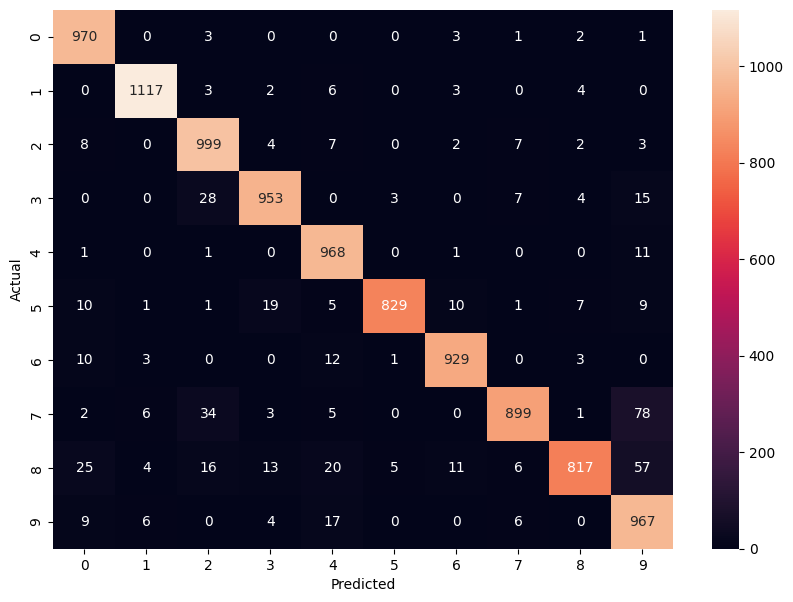

In [16]:
# theta.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# test_loss, test_accuracy = theta.evaluate(x_test, y_test, verbose=0)

# print(f"Test accuracy: {test_accuracy}")
y_pred = theta.predict(x_test, verbose=0)
# print(y_pred.shape)

y_pred_classes = np.argmax(y_pred, axis = 1) 

confusion_mtx = confusion_matrix(y_test, y_pred_classes) 

accuracy = accuracy_score(y_test, y_pred_classes)

print(f'Test accuracy: {accuracy}')
plt.figure(figsize=(10,7))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **With Regular Quantization**

In [76]:
theta_r = create_model()
theta_hat_r = create_model()
# print(theta_hat_r.get_weights())
RLFL_ACCs = []
RLFL_LOSSes = []
deltas_r = [None for _ in range(N)]


for epoch in tqdm(range(epochs)):
    broadcast = quantize_model_weights(subtract_weights(theta_r.get_weights(), theta_hat_r.get_weights()), q1, stochastic=False)
    theta_hat_r.set_weights(add_weights(theta_hat_r.get_weights(), broadcast))
#     print(theta_hat_r.get_weights())
#     break
    for i in range(N):
        model = create_model()
        model.set_weights(theta_hat_r.get_weights())
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#         model.fit(x_train_split[i], y_train_split[i], epochs=tau, verbose=0)
        for j in range(tau):
            xj, yj = get_mini_batch(x_train_split[i], y_train_split[i], 500)
            with tf.GradientTape() as tape:
                predictions = model(xj)
                loss = tf.keras.losses.sparse_categorical_crossentropy(yj, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#         print(model.get_weights())
        d = subtract_weights(model.get_weights(), theta_hat_r.get_weights())
#         print(d)
        delta = deltas_r[i]
        if delta!=None:
            d = add_weights(delta, d)
        temp_d = quantize_model_weights(d, q2, stochastic=False)
#         print(temp_d)
        deltas_r[i] = subtract_weights(d, temp_d)
        models[i].set_weights(temp_d)   
    weight_updates = aggregate_models(models, [x_train_split[i].shape[0]/60000 for i in range(N)], return_model=False)
    theta_r.set_weights(add_weights(theta_r.get_weights(), weight_updates))
    theta_r.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    loss, acc = theta_r.evaluate(x_test, y_test, verbose=0)
    RLFL_ACCs.append(acc)
    RLFL_LOSSes.append(loss)

100%|██████████| 25/25 [05:39<00:00, 13.56s/it]


In [18]:
data = {'Loss': RLFL_LOSSes, 'Accuracy': RLFL_ACCs}
with open('regular_quantization.pkl', 'wb') as f:
    pickle.dump(data, f)
global_model.save('regular_quantization.h5')

In [ ]:
# from tensorflow.keras.models import load_model
# loaded_model = load_model('regular_quantization.h5')
# with open('regular_quantization.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)
# RLFL_LOSSes = loaded_data['Loss']
# RLFL_ACCs = loaded_data['Accuracy']

(10000, 10)
Test accuracy: 0.9513


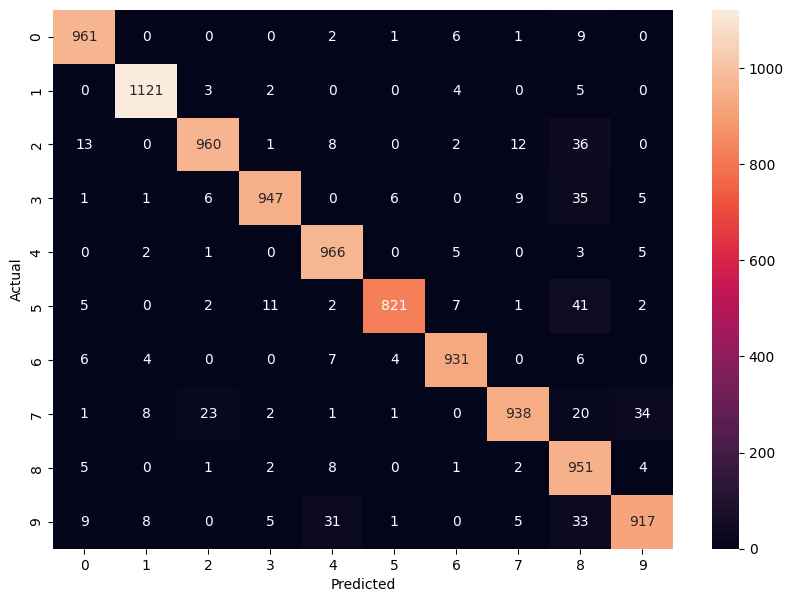

In [77]:
y_pred = theta_r.predict(x_test, verbose=0)
print(y_pred.shape)

y_pred_classes = np.argmax(y_pred, axis = 1) 

confusion_mtx = confusion_matrix(y_test, y_pred_classes) 

accuracy = accuracy_score(y_test, y_pred_classes)

print(f'Test accuracy: {accuracy}')
plt.figure(figsize=(10,7))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Comparison**

Text(0.5, 1.0, 'Accuracy of Federated Learning')

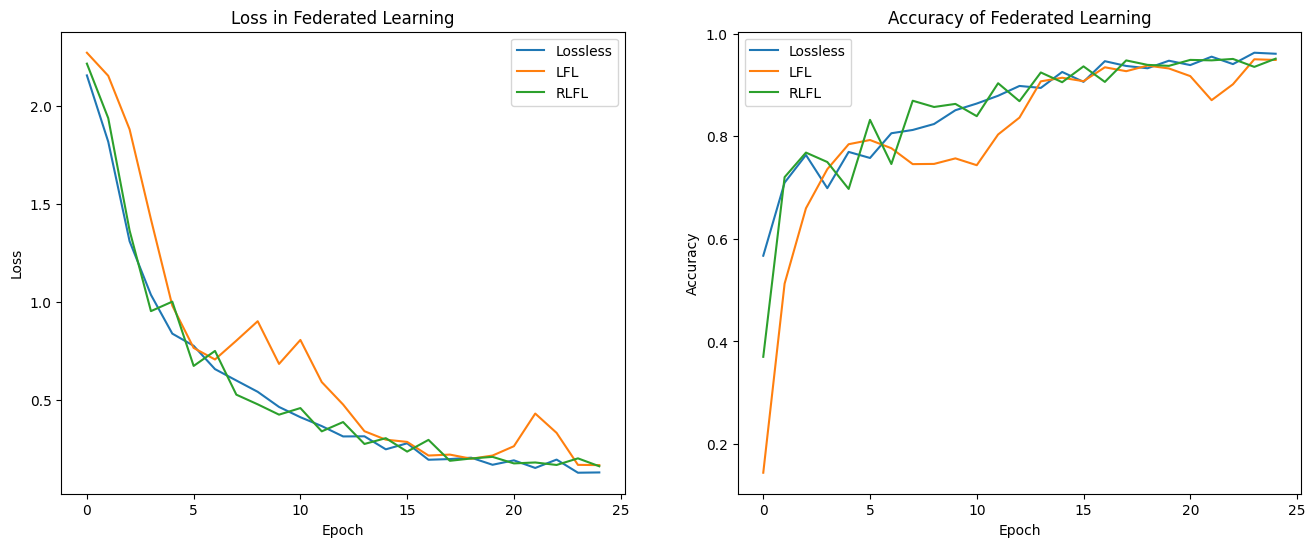

In [82]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(LOSSes, label="Lossless")
plt.plot(LFL_LOSSes, label="LFL")
plt.plot(RLFL_LOSSes, label="RLFL")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss in Federated Learning")
plt.legend()
plt.subplot(1,2,2)
plt.plot(ACCs, label="Lossless")
plt.plot(LFL_ACCs, label="LFL")
plt.plot(RLFL_ACCs, label="RLFL")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy of Federated Learning")